In [1]:
# =============================================================================
# GPU MEMORY CLEANUP - Run this first to ensure clean state
# =============================================================================

import torch
import gc
import psutil
import os

def clear_gpu_memory():
    """Clear all GPU memory and run garbage collection"""
    print("🧹 Clearing GPU memory...")
    
    # Force garbage collection
    gc.collect()
    
    # Clear CUDA cache if available
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        
        # Get GPU memory info
        for i in range(torch.cuda.device_count()):
            gpu_memory = torch.cuda.get_device_properties(i).total_memory / 1024**3
            allocated = torch.cuda.memory_allocated(i) / 1024**3
            cached = torch.cuda.memory_reserved(i) / 1024**3
            print(f"   GPU {i}: {allocated:.2f}GB allocated, {cached:.2f}GB cached of {gpu_memory:.2f}GB total")
        
        # Clear again after getting info
        torch.cuda.empty_cache()
        print("   ✅ CUDA cache cleared")
    else:
        print("   ⚠️  CUDA not available")
    
    # Get system memory info
    memory = psutil.virtual_memory()
    print(f"   💾 System RAM: {memory.used / 1024**3:.2f}GB used of {memory.total / 1024**3:.2f}GB total")
    
    print("   🗑️  Garbage collection completed")
    print("=" * 60)

# Clear memory at startup
clear_gpu_memory()

# Optional: Set memory management flags
if torch.cuda.is_available():
    # Prevent memory fragmentation
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
    print("🔧 PyTorch CUDA memory management configured")
    print("=" * 60)

# Check if models are loaded and discard them if so
if 'llada_model' in globals():
    del llada_model
    gc.collect()
    torch.cuda.empty_cache()

if 'vllm_model' in globals():
    del vllm_model
    gc.collect()
    torch.cuda.empty_cache()


🧹 Clearing GPU memory...
   GPU 0: 0.00GB allocated, 0.00GB cached of 79.33GB total
   ✅ CUDA cache cleared
   💾 System RAM: 90.04GB used of 2015.68GB total
   🗑️  Garbage collection completed
🔧 PyTorch CUDA memory management configured


In [2]:
import torch
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import gc # For garbage collection
from vllm import LLM, SamplingParams
import sys
import os
from pathlib import Path

# Note: Paths will be discovered dynamically in the next cell

# --- Configuration ---
LLADA_MODEL_NAME = "GSAI-ML/LLaDA-8B-Instruct"
LLAMA3_MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Load Tokenizers ---
print("Loading tokenizers...")
llada_tokenizer = AutoTokenizer.from_pretrained(LLADA_MODEL_NAME, trust_remote_code=True)
llama3_tokenizer = AutoTokenizer.from_pretrained(LLAMA3_MODEL_NAME)

# Add a padding token to Llama3 tokenizer if it doesn't exist
if llama3_tokenizer.pad_token is None:
    llama3_tokenizer.pad_token = llama3_tokenizer.eos_token
    
print(f"Tokenizers loaded. Models will be loaded on-demand to save memory.")
print(f"Using device: {DEVICE}")


/opt/nemo_rl_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 08-29 13:08:38 [__init__.py:243] Automatically detected platform cuda.


2025-08-29 13:08:39,946	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Loading tokenizers...
Tokenizers loaded. Models will be loaded on-demand to save memory.
Using device: cuda


In [3]:
# =============================================================================
# FAST-DLLM GENERATION REGISTRY IMPORT AND SETUP
# =============================================================================

def find_project_root(start_path=None, max_depth=10):
    """
    Dynamically find the NeMo-RL project root by walking up the directory tree.
    Looks for characteristic files/directories that indicate the project root.
    """
    if start_path is None:
        start_path = os.getcwd()
    
    # Markers that indicate we've found the NeMo-RL project root
    project_markers = [
        'pyproject.toml',
        'notebooks',
        'xp', 
        'nemo_rl',
        '3rdparty'
    ]
    
    current_dir = os.path.abspath(start_path)
    depth = 0
    
    print(f"🔍 Looking for project root starting from: {current_dir}")
    
    while depth < max_depth:
        print(f"  Checking: {current_dir}")
        
        # Check if current directory contains project markers
        try:
            dir_contents = os.listdir(current_dir)
            found_markers = [marker for marker in project_markers if marker in dir_contents]
            
            print(f"    Found markers: {found_markers}")
            
            # If we find multiple key markers, this is likely the project root
            if len(found_markers) >= 3:  # Need at least 3 markers
                print(f"  ✅ Found project root: {current_dir}")
                return current_dir
                
        except PermissionError:
            print(f"    ❌ Permission denied")
        except Exception as e:
            print(f"    ❌ Error: {e}")
        
        # Move up one directory
        parent_dir = os.path.dirname(current_dir)
        if parent_dir == current_dir:  # Reached filesystem root
            break
        current_dir = parent_dir
        depth += 1
    
    print(f"  ❌ Could not find project root within {max_depth} levels")
    return None

def find_fast_dllm_path(project_root):
    """
    Find Fast-dLLM installation starting from project root.
    """
    if not project_root:
        return None
    
    print(f"\n🔍 Searching for Fast-dLLM from project root: {project_root}")
    
    # Common Fast-dLLM subdirectories to check
    fast_dllm_subdirs = [
        '3rdparty/Fast-dLLM/llada',
        '3rdparty/fast-dllm/llada',
        'Fast-dLLM/llada',
        'fast-dllm/llada',
        'external/Fast-dLLM/llada',
        'deps/Fast-dLLM/llada',
    ]
    
    for subdir in fast_dllm_subdirs:
        candidate_path = os.path.join(project_root, subdir)
        print(f"  Checking: {candidate_path}")
        
        if os.path.exists(candidate_path):
            print(f"  ✅ Found directory!")
            
            # Verify it has the expected model file
            model_file = os.path.join(candidate_path, 'model', 'modeling_llada.py')
            if os.path.exists(model_file):
                print(f"  ✅ Verified model file exists: modeling_llada.py")
                return candidate_path
            else:
                print(f"  ⚠️  Directory exists but missing model/modeling_llada.py")
                try:
                    contents = os.listdir(candidate_path)
                    print(f"      Contents: {contents[:5]}")
                except:
                    print(f"      Could not list contents")
        else:
            print(f"  ❌ Not found")
    
    return None

# Dynamic project discovery
print("🚀 Starting dynamic Fast-dLLM discovery...")
dynamic_project_root = find_project_root()

# Find Fast-dLLM
fast_dllm_path = find_fast_dllm_path(dynamic_project_root)

# Try to import Fast-dLLM model class
LLaDAModelLM = None
if fast_dllm_path:
    sys.path.insert(0, fast_dllm_path)
    print(f"\n✅ Added Fast-dLLM path to sys.path: {fast_dllm_path}")
    try:
        from model.modeling_llada import LLaDAModelLM
        print("✅ Fast-dLLM model class imported successfully!")
    except ImportError as e:
        print(f"⚠️ Failed to import Fast-dLLM model class: {e}")
        print(f"   Contents of {fast_dllm_path}:")
        try:
            for item in sorted(os.listdir(fast_dllm_path)):
                item_path = os.path.join(fast_dllm_path, item)
                if os.path.isdir(item_path):
                    print(f"     📁 {item}/")
                else:
                    print(f"     📄 {item}")
        except Exception as ex:
            print(f"     Could not list contents: {ex}")
        LLaDAModelLM = None
else:
    print(f"\n❌ Fast-dLLM not found")
    if dynamic_project_root:
        print(f"   📁 Project root found at: {dynamic_project_root}")
        print(f"   💡 Try installing Fast-dLLM in: {dynamic_project_root}/3rdparty/Fast-dLLM/")
    else:
        print(f"   📁 Could not locate project root directory")
        print(f"   💡 Make sure you're running from within the NeMo-RL project")

def find_llada_generate_path(project_root):
    """
    Find the llada_generate module path dynamically.
    """
    if not project_root:
        return None
    
    print(f"\n🔍 Searching for llada_generate module from project root: {project_root}")
    
    # Common locations for llada_generate
    llada_generate_locations = [
        'xp/llada_api',
        'llada_api', 
        'api',
        'src',
    ]
    
    for location in llada_generate_locations:
        candidate_path = os.path.join(project_root, location)
        llada_generate_path = os.path.join(candidate_path, 'llada_generate')
        
        print(f"  Checking: {llada_generate_path}")
        
        if os.path.exists(llada_generate_path):
            # Check if it's a proper Python module
            init_file = os.path.join(llada_generate_path, '__init__.py')
            if os.path.exists(init_file):
                print(f"  ✅ Found llada_generate module!")
                return candidate_path
            else:
                print(f"  ⚠️  Directory exists but missing __init__.py")
        else:
            print(f"  ❌ Not found")
    
    return None

# Find and add llada_generate to path
print("\n🔍 Looking for llada_generate module...")
llada_generate_parent_path = find_llada_generate_path(dynamic_project_root)

FAST_DLLM_AVAILABLE = False
if llada_generate_parent_path:
    if llada_generate_parent_path not in sys.path:
        sys.path.insert(0, llada_generate_parent_path)
        print(f"✅ Added llada_generate parent path: {llada_generate_parent_path}")
    
    try:
        # Import generation registry and algorithms
        from llada_generate import (
            get_algorithm, 
            list_available_algorithms,
            list_algorithms,
            GenerationAlgorithm,
            registry
        )
        
        FAST_DLLM_AVAILABLE = True
        print("✅ Fast-dLLM generation registry imported successfully!")
        
        # List all registered algorithms
        all_algorithms = list_algorithms()
        available_algorithms = list_available_algorithms()
        
        print(f"\n📋 Total registered algorithms: {len(all_algorithms)}")
        for name in all_algorithms:
            status = "✅ Available" if name in available_algorithms else "❌ Not available"
            algo_info = registry.get_algorithm_info(name)
            if algo_info:
                print(f"   {name}: {status} - {algo_info.get('description', 'No description')}")
            else:
                print(f"   {name}: {status}")
        
        print(f"\n🚀 Available for benchmarking: {len(available_algorithms)} algorithms")
        print(f"   {available_algorithms}")
        
    except ImportError as e:
        FAST_DLLM_AVAILABLE = False
        print(f"❌ Failed to import Fast-dLLM generation registry: {e}")
        print(f"   Path was added: {llada_generate_parent_path}")
        print(f"   Contents of llada_generate directory:")
        try:
            llada_generate_dir = os.path.join(llada_generate_parent_path, 'llada_generate')
            for item in sorted(os.listdir(llada_generate_dir)):
                item_path = os.path.join(llada_generate_dir, item)
                if os.path.isdir(item_path):
                    print(f"     📁 {item}/")
                else:
                    print(f"     📄 {item}")
        except Exception as ex:
            print(f"     Could not list contents: {ex}")
else:
    print(f"❌ Could not find llada_generate module")
    if dynamic_project_root:
        print(f"   📁 Project root: {dynamic_project_root}")
        print(f"   📁 Expected location: {dynamic_project_root}/xp/llada_api/llada_generate/")
        print(f"   💡 Check if the llada_generate directory exists with proper __init__.py")
    else:
        print(f"   📁 Could not locate project root")


🚀 Starting dynamic Fast-dLLM discovery...
🔍 Looking for project root starting from: /lustre/fsw/portfolios/llmservice/users/mfathi/codebases/NeMo-RL
  Checking: /lustre/fsw/portfolios/llmservice/users/mfathi/codebases/NeMo-RL
    Found markers: ['pyproject.toml', 'notebooks', 'xp', 'nemo_rl', '3rdparty']
  ✅ Found project root: /lustre/fsw/portfolios/llmservice/users/mfathi/codebases/NeMo-RL

🔍 Searching for Fast-dLLM from project root: /lustre/fsw/portfolios/llmservice/users/mfathi/codebases/NeMo-RL
  Checking: /lustre/fsw/portfolios/llmservice/users/mfathi/codebases/NeMo-RL/3rdparty/Fast-dLLM/llada
  ✅ Found directory!
  ✅ Verified model file exists: modeling_llada.py

✅ Added Fast-dLLM path to sys.path: /lustre/fsw/portfolios/llmservice/users/mfathi/codebases/NeMo-RL/3rdparty/Fast-dLLM/llada
✅ Fast-dLLM model class imported successfully!

🔍 Looking for llada_generate module...

🔍 Searching for llada_generate module from project root: /lustre/fsw/portfolios/llmservice/users/mfathi/co

In [4]:
# =============================================================================
# BENCHMARKING PARAMETERS CONFIGURATION
# =============================================================================

# --- Fast-dLLM Generation Parameters ---
FAST_DLLM_CONFIG = {
    # Core diffusion parameters
    'steps_per_block': 32,      # Number of diffusion steps per block (more intuitive than total steps)
    'block_length': 32,         # Block length for generation
    'temperature': 0.7,        # Sampling temperature (0.0 = deterministic)
    'remasking': 'low_confidence', # Remasking strategy
    'threshold': 0.9,          # Threshold for algorithms that support it
    'factor': None,             # Factor for algorithms that support it
}

# --- vLLM Generation Parameters ---
VLLM_CONFIG = {
    'temperature': 0.0,         # 0.0 = greedy, >0.0 = sampling
    'top_k': -1,                # Top-k sampling (-1 = disabled)
    'top_p': 1.0,               # Top-p (nucleus) sampling (1.0 = disabled)
    'repetition_penalty': 1.0,  # Penalty for repeating tokens
    'frequency_penalty': 0.0,   # Penalty for frequent tokens
    'presence_penalty': 0.0,    # Penalty for tokens that have appeared
    'min_tokens': 0,           # Minimum number of tokens to generate
    'stop_sequences': None,     # List of strings that stop generation
    'n': 1,                    # Number of completions to generate
    'best_of': 1,              # Number of candidates to generate and return best
}

# --- Benchmarking Parameters ---
BENCHMARK_CONFIG = {
    'prompt_text': "Explain the theory of general relativity in comprehensive detail.",
    'generation_lengths': [256, 512, 768, 1024],  # Token lengths to benchmark
    'num_trials': 1,                               # Number of trials per benchmark
    'show_generated_text': True,                   # Whether to display generated text
    'gpu_memory_utilization': 0.9,                # GPU memory limit for vLLM
}

print("✅ Benchmarking parameters configured:")
print(f"   Fast-dLLM: {FAST_DLLM_CONFIG['steps_per_block']} steps/block, block_length={FAST_DLLM_CONFIG['block_length']}, temp={FAST_DLLM_CONFIG['temperature']}")
print(f"   vLLM: temp={VLLM_CONFIG['temperature']}, top_p={VLLM_CONFIG['top_p']}")
print(f"   Benchmark: {len(BENCHMARK_CONFIG['generation_lengths'])} lengths, {BENCHMARK_CONFIG['num_trials']} trials each")
print(f"   Generation lengths: {BENCHMARK_CONFIG['generation_lengths']}")


✅ Benchmarking parameters configured:
   Fast-dLLM: 32 steps/block, block_length=32, temp=0.7
   vLLM: temp=0.0, top_p=1.0
   Benchmark: 4 lengths, 1 trials each
   Generation lengths: [256, 512, 768, 1024]


In [5]:
# =============================================================================
# BENCHMARKING FRAMEWORK
# =============================================================================

# Extract parameters from BENCHMARK_CONFIG
PROMPT_TEXT = BENCHMARK_CONFIG['prompt_text']
GENERATION_LENGTHS = BENCHMARK_CONFIG['generation_lengths']
NUM_TRIALS = BENCHMARK_CONFIG['num_trials']

def run_benchmark(model_name, gen_function, tokenizer, gen_length, print_text=False, **kwargs):
    """
    Runs the generation benchmark for a given model and returns timing statistics.
    """
    total_time = 0
    total_tokens = 0
    generated_texts = []
    forward_passes = []
    
    # Warm-up run
    print(f"  Warm-up run for {gen_length} tokens...")
    try:
        result = gen_function(
            model=kwargs.get('model'), 
            tokenizer=tokenizer, 
            prompt_text=PROMPT_TEXT, 
            gen_length=gen_length,
            **kwargs.get('func_args', {})
        )
        # Handle different return formats
        if isinstance(result, tuple):
            warmup_text, warmup_nfe = result
        else:
            warmup_text = result
            warmup_nfe = None
        torch.cuda.synchronize()
    except Exception as e:
        print(f"  ⚠️ Warm-up failed: {e}")

    # Timed trials
    for i in range(NUM_TRIALS):
        print(f"  Trial {i+1}/{NUM_TRIALS} for {gen_length} tokens...")
        start_time = time.time()
        
        try:
            result = gen_function(
                model=kwargs.get('model'), 
                tokenizer=tokenizer, 
                prompt_text=PROMPT_TEXT, 
                gen_length=gen_length,
                **kwargs.get('func_args', {})
            )
            
            # Handle different return formats
            if isinstance(result, tuple):
                generated_text, nfe = result
                forward_passes.append(nfe)
            else:
                generated_text = result
                forward_passes.append(None)
                
        except Exception as e:
            print(f"  ❌ Trial {i+1} failed: {e}")
            generated_text = f"[ERROR: {e}]"
            forward_passes.append(None)
        
        torch.cuda.synchronize()
        end_time = time.time()
        
        elapsed_time = end_time - start_time
        num_tokens = len(tokenizer.encode(generated_text)) if generated_text and not generated_text.startswith('[ERROR') else 0
        
        total_time += elapsed_time
        total_tokens += num_tokens
        generated_texts.append(generated_text)
        
        # Print generated text if requested and it's the first trial
        if print_text and i == 0 and generated_text and not generated_text.startswith('[ERROR'):
            print(f"    📝 Generated Text (Trial {i+1}):")
            print(f"    {'-' * 50}")
            preview = generated_text[:300] + ('...' if len(generated_text) > 300 else '')
            for line in preview.split('\n'):
                print(f"    {line}")
            print(f"    {'-' * 50}")
            nfe_info = f", NFE: {forward_passes[-1]}" if forward_passes[-1] is not None else ""
            print(f"    Tokens: {num_tokens}, Time: {elapsed_time:.2f}s{nfe_info}")
            print()

    avg_time = total_time / NUM_TRIALS if NUM_TRIALS > 0 else 0
    avg_tokens = total_tokens / NUM_TRIALS if NUM_TRIALS > 0 else 0
    tokens_per_sec = avg_tokens / avg_time if avg_time > 0 else 0
    avg_nfe = sum(nfe for nfe in forward_passes if nfe is not None) / len([nfe for nfe in forward_passes if nfe is not None]) if forward_passes and any(nfe is not None for nfe in forward_passes) else None
    
    result = {
        "Model": model_name,
        "Gen Length": gen_length,
        "Avg Time (s)": avg_time,
        "Avg Tokens": avg_tokens,
        "Tokens/Sec": tokens_per_sec,
        "Avg NFE": avg_nfe
    }
    
    # Add generated texts to result if requested
    if print_text:
        result["Generated_Texts"] = generated_texts
    
    return result

print("✅ Benchmarking framework loaded.")


✅ Benchmarking framework loaded.


In [6]:
# =============================================================================
# FAST-DLLM GENERATION FUNCTIONS
# =============================================================================

@torch.no_grad()
def fast_dllm_generate(model, tokenizer, prompt_text, gen_length=512, algorithm_name="dual_cache", **config):
    """
    Generate text using Fast-dLLM algorithm.
    Returns tuple of (generated_text, num_forward_evaluations)
    """
    try:
        if not FAST_DLLM_AVAILABLE:
            raise RuntimeError("Fast-dLLM is not available")
        
        # Get the algorithm
        algorithm = get_algorithm(algorithm_name)
        if algorithm is None:
            raise RuntimeError(f"Algorithm '{algorithm_name}' not found")
        
        if not algorithm.is_available():
            raise RuntimeError(f"Algorithm '{algorithm_name}' is not available")
        
        # Format prompt for instruct model
        messages = [{"role": "user", "content": prompt_text}]
        formatted_prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
        input_ids = tokenizer(formatted_prompt, return_tensors="pt")['input_ids'].to(DEVICE)
        
        print(f"    🔧 Debug: prompt shape={input_ids.shape}, device={input_ids.device}")
        print(f"    🔧 Debug: model device={next(model.parameters()).device}")
        
        # Get algorithm configuration
        steps_per_block = config.get('steps_per_block', FAST_DLLM_CONFIG['steps_per_block'])
        block_length = config.get('block_length', FAST_DLLM_CONFIG['block_length'])
        temperature = config.get('temperature', FAST_DLLM_CONFIG['temperature'])
        remasking = config.get('remasking', FAST_DLLM_CONFIG['remasking'])
        threshold = config.get('threshold', FAST_DLLM_CONFIG['threshold'])
        factor = config.get('factor', FAST_DLLM_CONFIG['factor'])
        
        # Ensure gen_length is compatible with block_length if needed
        if gen_length % block_length != 0:
            adjusted_gen_length = ((gen_length // block_length) + 1) * block_length
            print(f"    ⚠️ Adjusted gen_length from {gen_length} to {adjusted_gen_length} to be compatible with block_length {block_length}")
            gen_length = adjusted_gen_length
        
        # Calculate total steps from steps_per_block (much clearer!)
        num_blocks = gen_length // block_length
        total_steps = steps_per_block * num_blocks
        
        print(f"    🔧 Debug: steps_per_block={steps_per_block}, block_length={block_length}, gen_length={gen_length}")
        print(f"    🔧 Debug: num_blocks={num_blocks}, total_steps={total_steps}")
        print(f"    🔧 Debug: temp={temperature}, remasking={remasking}, threshold={threshold}, factor={factor}")
        
        print(f"    🔧 Final parameters: total_steps={total_steps}, gen_length={gen_length}, block_length={block_length}")
        print(f"    🔧 Validation: {total_steps} % {num_blocks} = {total_steps % num_blocks} (guaranteed to be 0)")
        
        # Check what parameters the algorithm actually accepts
        import inspect
        sig = inspect.signature(algorithm.generate)
        print(f"    🔧 Debug: Algorithm.generate signature: {sig}")
        
        # Generate using the algorithm with error handling
        print(f"    🚀 Calling {algorithm_name}.generate...")
        output, nfe = algorithm.generate(
            model=model,
            prompt=input_ids,
            steps=total_steps,  # Use calculated total_steps = steps_per_block * num_blocks
            gen_length=gen_length,
            block_length=block_length,
            temperature=temperature,
            remasking=remasking,
            threshold=threshold,
            factor=factor
        )
        print(f"    ✅ Generation completed with NFE={nfe}")
        
        print(f"    🔧 Debug: output shape={output.shape}")
        
        # Decode only the generated part (excluding input)
        generated_text = tokenizer.batch_decode(output[:, input_ids.shape[1]:], skip_special_tokens=True)[0]
        
        print(f"    ✅ Generated {len(generated_text)} characters")
        return generated_text, nfe
        
    except Exception as e:
        print(f"    💥 Detailed error in fast_dllm_generate: {type(e).__name__}")
        print(f"    💥 Error message: {str(e)}")
        print(f"    💥 Error args: {e.args}")
        import traceback
        traceback.print_exc()
        raise RuntimeError(f"Fast-dLLM generation failed: {type(e).__name__}: {str(e)}") from e

# vLLM generation function (from original notebook)
def vllm_generate(model, tokenizer, prompt_text, gen_length=512, config=None):
    """
    Generates text using the vLLM engine with configurable parameters.
    Uses VLLM_CONFIG by default, but can be overridden with custom config.
    """
    if config is None:
        config = VLLM_CONFIG
    
    # The tokenizer is used for creating the prompt, but vLLM handles tokenization internally
    messages = [{"role": "user", "content": prompt_text}]
    prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    
    # Extract parameters with proper validation
    temperature = config.get('temperature', 0.0)
    top_k = config.get('top_k', -1)
    top_p = config.get('top_p', 1.0)
    n = config.get('n', 1)
    best_of = config.get('best_of', 1)
    
    # Ensure best_of >= n (required by vLLM)
    if best_of < n:
        best_of = n
    
    # Handle stop sequences properly
    stop_sequences = config.get('stop_sequences')
    if stop_sequences == [] or stop_sequences is None:
        stop_sequences = None
    
    # Create sampling parameters with only supported parameters
    try:
        sampling_params = SamplingParams(
            n=n,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            repetition_penalty=config.get('repetition_penalty', 1.0),
            frequency_penalty=config.get('frequency_penalty', 0.0),
            presence_penalty=config.get('presence_penalty', 0.0),
            max_tokens=gen_length,
            min_tokens=config.get('min_tokens', 0),
            stop=stop_sequences,
            best_of=best_of,
        )
    except TypeError as e:
        # Fallback for older vLLM versions with fewer parameters
        print(f"⚠️  Parameter not supported in this vLLM version, using basic parameters: {e}")
        sampling_params = SamplingParams(
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            max_tokens=gen_length,
            stop=stop_sequences,
        )
    
    # Generate text
    outputs = model.generate(prompt, sampling_params)
    
    # Return the generated text from the first output
    return outputs[0].outputs[0].text

print("✅ Fast-dLLM and vLLM generation functions loaded.")


✅ Fast-dLLM and vLLM generation functions loaded.


In [7]:
# =============================================================================
# LOAD LLADA MODEL FOR FAST-DLLM BENCHMARKING
# =============================================================================

print(f"Loading LLaDA model: {LLADA_MODEL_NAME}...")

# Use Fast-dLLM optimized model if available
if FAST_DLLM_AVAILABLE and LLaDAModelLM is not None:
    print("🚀 Using Fast-dLLM optimized model class (LLaDAModelLM)")
    llada_model = LLaDAModelLM.from_pretrained(
        LLADA_MODEL_NAME, 
        trust_remote_code=True, 
        torch_dtype=torch.bfloat16
    ).to(DEVICE).eval()
else:
    print("⚠️ Fast-dLLM model class not available, falling back to standard AutoModel")
    print("   Note: Some Fast-dLLM algorithms may not work properly with AutoModel")
    llada_model = AutoModel.from_pretrained(
        LLADA_MODEL_NAME, 
        trust_remote_code=True, 
        torch_dtype=torch.bfloat16
    ).to(DEVICE).eval()

print("✅ LLaDA model loaded successfully!")

# Test that the model works with at least one algorithm
if FAST_DLLM_AVAILABLE and available_algorithms:
    test_algorithm = available_algorithms[0]
    print(f"\n🧪 Testing model with '{test_algorithm}' algorithm...")
    try:
        test_text, test_nfe = fast_dllm_generate(
            model=llada_model,
            tokenizer=llada_tokenizer,
            prompt_text="Hello, how are you?",
            gen_length=32,
            algorithm_name=test_algorithm
        )
        print(f"✅ Test successful! Generated {len(test_text)} characters with {test_nfe} forward passes")
        print(f"   Sample output: {test_text[:100]}{'...' if len(test_text) > 100 else ''}")
    except Exception as e:
        print(f"❌ Test failed: {e}")
        print("   This might indicate an issue with the Fast-dLLM setup")
        if LLaDAModelLM is None:
            print("   💡 Hint: Fast-dLLM model class is not available - check Fast-dLLM installation")


Loading LLaDA model: GSAI-ML/LLaDA-8B-Instruct...
🚀 Using Fast-dLLM optimized model class (LLaDAModelLM)


Loading checkpoint shards: 100%|██████████| 6/6 [00:00<00:00, 97.68it/s]


✅ LLaDA model loaded successfully!

🧪 Testing model with 'basic' algorithm...
    🔧 Debug: prompt shape=torch.Size([1, 19]), device=cuda:0
    🔧 Debug: model device=cuda:0
    🔧 Debug: steps_per_block=32, block_length=32, gen_length=32
    🔧 Debug: num_blocks=1, total_steps=32
    🔧 Debug: temp=0.7, remasking=low_confidence, threshold=0.9, factor=None
    🔧 Final parameters: total_steps=32, gen_length=32, block_length=32
    🔧 Validation: 32 % 1 = 0 (guaranteed to be 0)
    🔧 Debug: Algorithm.generate signature: (model: transformers.modeling_utils.PreTrainedModel, prompt: torch.Tensor, steps: int, gen_length: int, block_length: int, temperature: float = 1.0, remasking: bool = True, threshold: float = 0.95, factor: float = 1.0, **kwargs) -> Tuple[torch.Tensor, int]
    🚀 Calling basic.generate...
    ✅ Generation completed with NFE=19
    🔧 Debug: output shape=torch.Size([1, 51])
    ✅ Generated 48 characters
✅ Test successful! Generated 48 characters with 19 forward passes
   Sample ou

In [8]:
# =============================================================================
# COMPREHENSIVE FAST-DLLM BENCHMARKING
# =============================================================================

results_list = []

if not FAST_DLLM_AVAILABLE or not available_algorithms:
    print("❌ Fast-dLLM is not available or no algorithms are available for benchmarking.")
    print("   Skipping Fast-dLLM benchmarks...")
else:
    print(f"\n🚀 Starting comprehensive Fast-dLLM benchmarking...")
    print(f"   Algorithms to test: {available_algorithms}")
    print(f"   Generation lengths: {GENERATION_LENGTHS}")
    print(f"   Trials per test: {NUM_TRIALS}")
    
    for algorithm_name in available_algorithms:
        print(f"\n{'='*60}")
        print(f"🔬 BENCHMARKING ALGORITHM: {algorithm_name.upper()}")
        print(f"{'='*60}")
        
        # Get algorithm info
        algorithm = get_algorithm(algorithm_name)
        if algorithm:
            print(f"📋 Description: {algorithm.description}")
        
        for i, gen_length in enumerate(GENERATION_LENGTHS):
            print(f"\n📏 Testing {algorithm_name} with {gen_length} tokens...")
            
            # Show sample text only for first length of each algorithm
            show_text = BENCHMARK_CONFIG['show_generated_text'] and (i == 0)
            
            try:
                result = run_benchmark(
                    f"Fast-dLLM ({algorithm_name})",
                    fast_dllm_generate,
                    llada_tokenizer,
                    gen_length,
                    print_text=show_text,
                    model=llada_model,
                    func_args={
                        'algorithm_name': algorithm_name,
                        **FAST_DLLM_CONFIG
                    }
                )
                results_list.append(result)
                
                # Print performance summary
                print(f"   ⚡ {algorithm_name}: {result['Tokens/Sec']:.2f} tokens/sec, {result['Avg Time (s)']:.2f}s avg", end="")
                if result['Avg NFE'] is not None:
                    print(f", {result['Avg NFE']:.1f} avg NFE")
                else:
                    print()
                
            except Exception as e:
                print(f"   ❌ Failed to benchmark {algorithm_name}: {e}")
                # Add failed result to maintain consistency
                failed_result = {
                    "Model": f"Fast-dLLM ({algorithm_name})",
                    "Gen Length": gen_length,
                    "Avg Time (s)": float('inf'),
                    "Avg Tokens": 0,
                    "Tokens/Sec": 0,
                    "Avg NFE": None
                }
                results_list.append(failed_result)
        
        # Memory cleanup between algorithms
        gc.collect()
        torch.cuda.empty_cache()

print(f"\n✅ Fast-dLLM benchmarking completed! Tested {len(available_algorithms) if FAST_DLLM_AVAILABLE else 0} algorithms.")



🚀 Starting comprehensive Fast-dLLM benchmarking...
   Algorithms to test: ['basic', 'prefix_cache', 'dual_cache']
   Generation lengths: [256, 512, 768, 1024]
   Trials per test: 1

🔬 BENCHMARKING ALGORITHM: BASIC
📋 Description: Basic LLaDA generation without caching for maximum compatibility

📏 Testing basic with 256 tokens...
  Warm-up run for 256 tokens...
    🔧 Debug: prompt shape=torch.Size([1, 23]), device=cuda:0
    🔧 Debug: model device=cuda:0
    🔧 Debug: steps_per_block=32, block_length=32, gen_length=256
    🔧 Debug: num_blocks=8, total_steps=256
    🔧 Debug: temp=0.7, remasking=low_confidence, threshold=0.9, factor=None
    🔧 Final parameters: total_steps=256, gen_length=256, block_length=32
    🔧 Validation: 256 % 8 = 0 (guaranteed to be 0)
    🔧 Debug: Algorithm.generate signature: (model: transformers.modeling_utils.PreTrainedModel, prompt: torch.Tensor, steps: int, gen_length: int, block_length: int, temperature: float = 1.0, remasking: bool = True, threshold: float = 

In [9]:
# Clear LLaDA model from memory before loading vLLM
print("\n🧹 Clearing LLaDA model from memory...")
if 'llada_model' in globals():
    del llada_model
    gc.collect()
    torch.cuda.empty_cache()
print("✅ LLaDA model cleared.")



🧹 Clearing LLaDA model from memory...
✅ LLaDA model cleared.


In [10]:
# =============================================================================
# VLLM BASELINE BENCHMARKING
# =============================================================================

print(f"\n{'='*60}")
print(f"🔬 BENCHMARKING BASELINE: vLLM Llama-3-8B")
print(f"{'='*60}")

print(f"\nLoading vLLM model: {LLAMA3_MODEL_NAME}...")
vllm_model = LLM(
    model=LLAMA3_MODEL_NAME, 
    trust_remote_code=True,
    gpu_memory_utilization=BENCHMARK_CONFIG['gpu_memory_utilization']
)
print("✅ vLLM model loaded successfully!")

for i, gen_length in enumerate(GENERATION_LENGTHS):
    print(f"\n📏 Testing vLLM with {gen_length} tokens...")
    
    # Show sample text only for first length
    show_text = BENCHMARK_CONFIG['show_generated_text'] and (i == 0)
    
    result = run_benchmark(
        "vLLM Llama-3-8B",
        vllm_generate,
        llama3_tokenizer,
        gen_length,
        print_text=show_text,
        model=vllm_model,
        func_args={'config': VLLM_CONFIG}
    )
    results_list.append(result)
    
    # Print performance summary
    print(f"   ⚡ vLLM: {result['Tokens/Sec']:.2f} tokens/sec, {result['Avg Time (s)']:.2f}s avg")

# Clear vLLM model from memory
print("\n🧹 Clearing vLLM model from memory...")
del vllm_model
gc.collect()
torch.cuda.empty_cache()
print("✅ vLLM model cleared.")

print("\n🎉 All benchmarking completed!")



🔬 BENCHMARKING BASELINE: vLLM Llama-3-8B

Loading vLLM model: meta-llama/Meta-Llama-3-8B-Instruct...
INFO 08-29 13:21:50 [__init__.py:31] Available plugins for group vllm.general_plugins:
INFO 08-29 13:21:50 [__init__.py:33] - lora_filesystem_resolver -> vllm.plugins.lora_resolvers.filesystem_resolver:register_filesystem_resolver
INFO 08-29 13:21:50 [__init__.py:36] All plugins in this group will be loaded. Set `VLLM_PLUGINS` to control which plugins to load.


INFO 08-29 13:22:00 [config.py:793] This model supports multiple tasks: {'embed', 'reward', 'score', 'generate', 'classify'}. Defaulting to 'generate'.
INFO 08-29 13:22:00 [config.py:2118] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 08-29 13:22:01 [utils.py:2531] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reason: CUDA is initialized
INFO 08-29 13:22:05 [__init__.py:243] Automatically detected platform cuda.
INFO 08-29 13:22:08 [core.py:438] Waiting for init message from front-end.
INFO 08-29 13:22:08 [__init__.py:31] Available plugins for group vllm.general_plugins:
INFO 08-29 13:22:08 [__init__.py:33] - lora_filesystem_resolver -> vllm.plugins.lora_resolvers.filesystem_resolver:register_filesystem_resolver
INFO 08-29 13:22:08 [__init__.py:36] All plugins in this group will be loaded. Set `VLLM

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:01<00:04,  1.47s/it]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.13it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:03<00:01,  1.13s/it]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:04<00:00,  1.12s/it]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:04<00:00,  1.12s/it]



INFO 08-29 13:22:33 [default_loader.py:280] Loading weights took 4.60 seconds
INFO 08-29 13:22:34 [gpu_model_runner.py:1549] Model loading took 14.9596 GiB and 23.703762 seconds
INFO 08-29 13:22:40 [backends.py:459] Using cache directory: /root/.cache/vllm/torch_compile_cache/0a93c7bbd1/rank_0_0 for vLLM's torch.compile
INFO 08-29 13:22:40 [backends.py:469] Dynamo bytecode transform time: 6.36 s
INFO 08-29 13:22:42 [backends.py:158] Cache the graph of shape None for later use
INFO 08-29 13:23:04 [backends.py:170] Compiling a graph for general shape takes 24.12 s
INFO 08-29 13:23:14 [monitor.py:33] torch.compile takes 30.48 s in total
INFO 08-29 13:23:14 [kv_cache_utils.py:637] GPU KV cache size: 443,648 tokens
INFO 08-29 13:23:14 [kv_cache_utils.py:640] Maximum concurrency for 8,192 tokens per request: 54.16x
INFO 08-29 13:23:50 [gpu_model_runner.py:1933] Graph capturing finished in 35 secs, took 0.52 GiB
INFO 08-29 13:23:50 [core.py:167] init engine (profile, create kv cache, warmup m

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it, est. speed input: 7.77 toks/s, output: 86.52 toks/s]


  Trial 1/1 for 256 tokens...


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it, est. speed input: 7.79 toks/s, output: 86.73 toks/s]


    📝 Generated Text (Trial 1):
    --------------------------------------------------
    A monumental task! Albert Einstein's theory of general relativity is a fundamental concept in modern physics that revolutionized our understanding of space, time, and gravity. I'll provide a comprehensive overview of the theory, breaking it down into its key components, mathematical formulations, an...
    --------------------------------------------------
    Tokens: 257, Time: 2.96s

   ⚡ vLLM: 86.93 tokens/sec, 2.96s avg

📏 Testing vLLM with 512 tokens...
  Warm-up run for 512 tokens...


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.94s/it, est. speed input: 3.88 toks/s, output: 86.27 toks/s]


  Trial 1/1 for 512 tokens...


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.94s/it, est. speed input: 3.88 toks/s, output: 86.28 toks/s]


   ⚡ vLLM: 86.37 tokens/sec, 5.94s avg

📏 Testing vLLM with 768 tokens...
  Warm-up run for 768 tokens...


Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.93s/it, est. speed input: 2.58 toks/s, output: 86.05 toks/s]


  Trial 1/1 for 768 tokens...


Processed prompts: 100%|██████████| 1/1 [00:08<00:00,  8.93s/it, est. speed input: 2.58 toks/s, output: 86.05 toks/s]


   ⚡ vLLM: 86.12 tokens/sec, 8.93s avg

📏 Testing vLLM with 1024 tokens...
  Warm-up run for 1024 tokens...


Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.92s/it, est. speed input: 1.93 toks/s, output: 85.88 toks/s]


  Trial 1/1 for 1024 tokens...


Processed prompts: 100%|██████████| 1/1 [00:11<00:00, 11.92s/it, est. speed input: 1.93 toks/s, output: 85.88 toks/s]


   ⚡ vLLM: 85.93 tokens/sec, 11.93s avg

🧹 Clearing vLLM model from memory...


[rank0]:[W829 13:24:51.379834412 ProcessGroupNCCL.cpp:1476] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


✅ vLLM model cleared.

🎉 All benchmarking completed!


In [11]:
# =============================================================================
# RESULTS ANALYSIS AND VISUALIZATION
# =============================================================================

# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

print("\n📊 COMPREHENSIVE BENCHMARKING RESULTS")
print("=" * 80)

# Display results table
display_df = results_df.copy()
display_df = display_df.round(3)
print(display_df.to_string(index=False))

# Summary statistics by model
print("\n📈 PERFORMANCE SUMMARY BY MODEL")
print("=" * 50)
summary = results_df.groupby('Model').agg({
    'Tokens/Sec': ['mean', 'max', 'min'],
    'Avg Time (s)': ['mean', 'max', 'min'],
    'Avg NFE': 'mean'
}).round(3)
print(summary)

# Find best performing algorithms
print("\n🏆 TOP PERFORMERS")
print("=" * 30)
best_overall = results_df.loc[results_df['Tokens/Sec'].idxmax()]
print(f"🥇 Fastest Overall: {best_overall['Model']} at {best_overall['Gen Length']} tokens")
print(f"   Speed: {best_overall['Tokens/Sec']:.2f} tokens/sec")

# Best per generation length
for gen_length in GENERATION_LENGTHS:
    subset = results_df[results_df['Gen Length'] == gen_length]
    if not subset.empty:
        best = subset.loc[subset['Tokens/Sec'].idxmax()]
        print(f"   📏 {gen_length} tokens: {best['Model']} ({best['Tokens/Sec']:.2f} tok/s)")

results_df



📊 COMPREHENSIVE BENCHMARKING RESULTS
                   Model  Gen Length  Avg Time (s)  Avg Tokens  Tokens/Sec  Avg NFE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

,Model,Gen Length,Avg Time (s),Avg Tokens,Tokens/Sec,Avg NFE,Generated_Texts
0,Fast-dLLM (basic),256,9.216659,254.0,27.558792,218.0,[General relativity is a theory of gravity pro...
1,Fast-dLLM (basic),512,22.014441,510.0,23.166611,321.0,NaN
2,Fast-dLLM (basic),768,39.144615,766.0,19.568464,376.0,NaN
3,Fast-dLLM (basic),1024,92.726725,1022.0,11.021634,777.0,NaN
4,Fast-dLLM (prefix_cache),256,8.468262,254.0,29.994348,218.0,[General relativity is a theory proposed by Al...
5,Fast-dLLM (prefix_cache),512,19.845620,510.0,25.698365,400.0,NaN
6,Fast-dLLM (prefix_cache),768,32.784292,766.0,23.364848,515.0,NaN
7,Fast-dLLM (prefix_cache),1024,55.941976,1022.0,18.268929,711.0,NaN
8,Fast-dLLM (dual_cache),256,9.874843,254.0,25.721929,225.0,"[The theory of general relativity, proposed by..."
9,Fast-dLLM (dual_cache),512,17.363234,510.0,29.372409,387.0,NaN


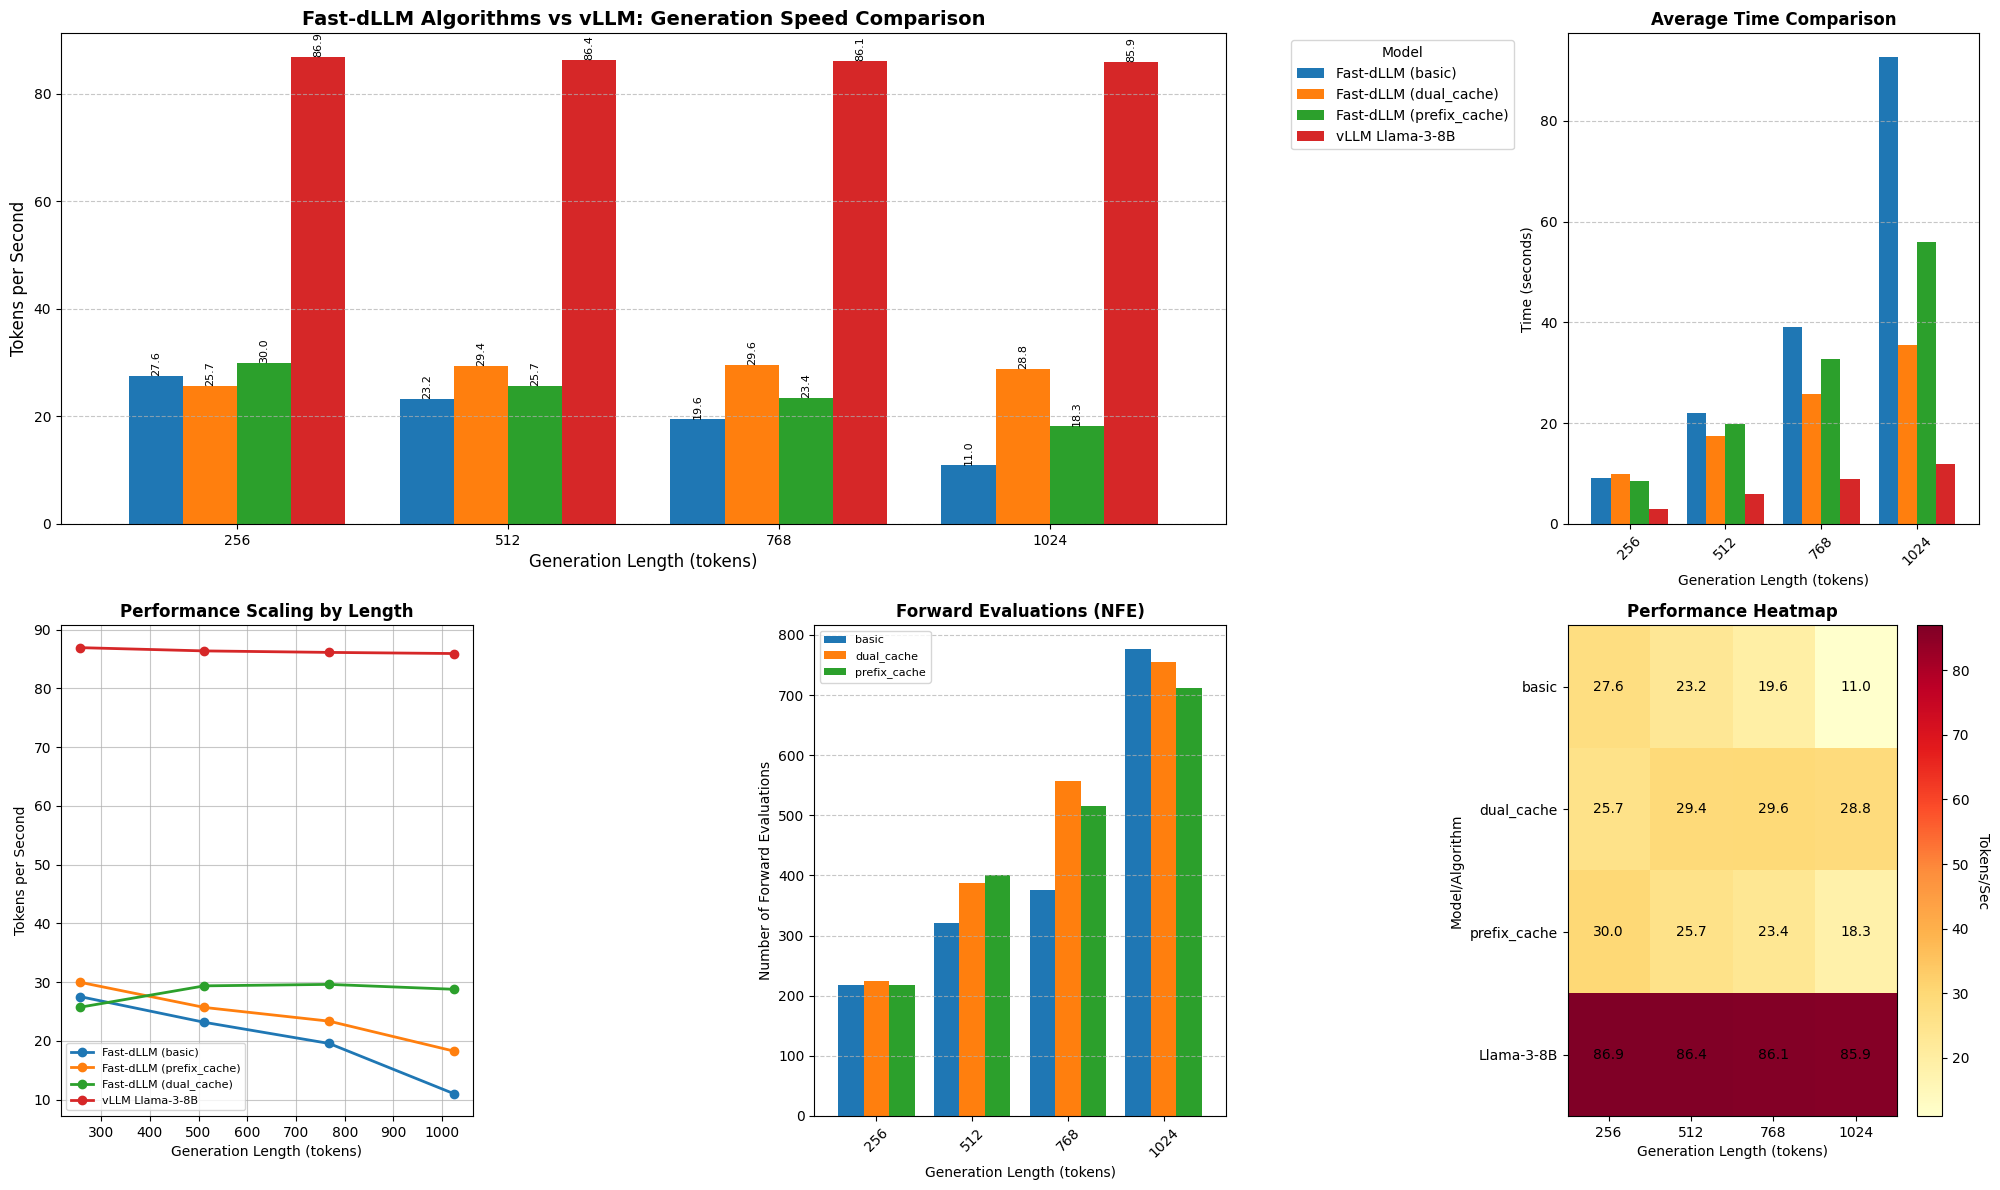

In [12]:
# =============================================================================
# COMPREHENSIVE VISUALIZATION
# =============================================================================

# Set up the plotting style
plt.style.use('default')

# Set up color palette manually
colors = plt.cm.tab10.colors  # Use matplotlib's tab10 colormap

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# 1. Main performance comparison - Tokens per second
ax1 = plt.subplot(2, 3, (1, 2))
pivot_df = results_df.pivot(index='Gen Length', columns='Model', values='Tokens/Sec')
pivot_df.plot(kind='bar', ax=ax1, width=0.8, color=colors[:len(pivot_df.columns)])
ax1.set_title('Fast-dLLM Algorithms vs vLLM: Generation Speed Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Generation Length (tokens)', fontsize=12)
ax1.set_ylabel('Tokens per Second', fontsize=12)
ax1.tick_params(axis='x', rotation=0)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.1f', label_type='edge', fontsize=8, rotation=90)

# 2. Average time comparison
ax2 = plt.subplot(2, 3, 3)
time_pivot = results_df.pivot(index='Gen Length', columns='Model', values='Avg Time (s)')
time_pivot.plot(kind='bar', ax=ax2, width=0.8, color=colors[:len(time_pivot.columns)])
ax2.set_title('Average Time Comparison', fontsize=12, fontweight='bold')
ax2.set_xlabel('Generation Length (tokens)', fontsize=10)
ax2.set_ylabel('Time (seconds)', fontsize=10)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend().set_visible(False)  # Hide legend since it's shown in main plot

# 3. Performance scaling
ax3 = plt.subplot(2, 3, 4)
color_idx = 0
for model in results_df['Model'].unique():
    model_data = results_df[results_df['Model'] == model]
    ax3.plot(model_data['Gen Length'], model_data['Tokens/Sec'], 'o-', 
            label=model, linewidth=2, markersize=6, color=colors[color_idx % len(colors)])
    color_idx += 1
ax3.set_title('Performance Scaling by Length', fontsize=12, fontweight='bold')
ax3.set_xlabel('Generation Length (tokens)', fontsize=10)
ax3.set_ylabel('Tokens per Second', fontsize=10)
ax3.grid(True, alpha=0.7)
ax3.legend(fontsize=8)

# 4. NFE (Number of Forward Evaluations) comparison for Fast-dLLM algorithms
ax4 = plt.subplot(2, 3, 5)
fast_dllm_results = results_df[results_df['Model'].str.contains('Fast-dLLM', na=False)].copy()
if not fast_dllm_results.empty and 'Avg NFE' in fast_dllm_results.columns:
    # Remove 'Fast-dLLM ' prefix for cleaner labels
    fast_dllm_results['Algorithm'] = fast_dllm_results['Model'].str.replace('Fast-dLLM (', '').str.replace(')', '')
    nfe_pivot = fast_dllm_results.pivot(index='Gen Length', columns='Algorithm', values='Avg NFE')
    nfe_pivot.plot(kind='bar', ax=ax4, width=0.8, color=colors[:len(nfe_pivot.columns)])
    ax4.set_title('Forward Evaluations (NFE)', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Generation Length (tokens)', fontsize=10)
    ax4.set_ylabel('Number of Forward Evaluations', fontsize=10)
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(axis='y', linestyle='--', alpha=0.7)
    ax4.legend(fontsize=8)
else:
    ax4.text(0.5, 0.5, 'No NFE data available', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Forward Evaluations (NFE)', fontsize=12, fontweight='bold')

# 5. Performance heatmap (using matplotlib instead of seaborn)
ax5 = plt.subplot(2, 3, 6)
heatmap_data = results_df.pivot(index='Model', columns='Gen Length', values='Tokens/Sec')
# Shorten model names for heatmap
heatmap_data.index = heatmap_data.index.str.replace('Fast-dLLM (', '').str.replace(')', '').str.replace('vLLM ', '')

# Create heatmap using matplotlib
im = ax5.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')

# Set ticks and labels
ax5.set_xticks(range(len(heatmap_data.columns)))
ax5.set_yticks(range(len(heatmap_data.index)))
ax5.set_xticklabels(heatmap_data.columns)
ax5.set_yticklabels(heatmap_data.index)

# Add text annotations
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        value = heatmap_data.iloc[i, j]
        if not pd.isna(value):
            ax5.text(j, i, f'{value:.1f}', ha='center', va='center', fontsize=10)

# Add colorbar
cbar = plt.colorbar(im, ax=ax5)
cbar.set_label('Tokens/Sec', rotation=270, labelpad=15)

ax5.set_title('Performance Heatmap', fontsize=12, fontweight='bold')
ax5.set_xlabel('Generation Length (tokens)', fontsize=10)
ax5.set_ylabel('Model/Algorithm', fontsize=10)

plt.tight_layout()
plt.show()


In [13]:
# =============================================================================
# DETAILED ANALYSIS AND INSIGHTS
# =============================================================================

print("\n🔍 DETAILED ANALYSIS")
print("=" * 80)

# Speed comparison against vLLM baseline
vllm_results = results_df[results_df['Model'].str.contains('vLLM', na=False)]
fast_dllm_results = results_df[results_df['Model'].str.contains('Fast-dLLM', na=False)]

if not vllm_results.empty and not fast_dllm_results.empty:
    print("\n⚡ SPEED ANALYSIS vs vLLM Baseline:")
    print("-" * 40)
    
    for gen_length in GENERATION_LENGTHS:
        vllm_speed = vllm_results[vllm_results['Gen Length'] == gen_length]['Tokens/Sec'].iloc[0] if len(vllm_results[vllm_results['Gen Length'] == gen_length]) > 0 else 0
        fast_dllm_subset = fast_dllm_results[fast_dllm_results['Gen Length'] == gen_length]
        
        print(f"\n📏 {gen_length} tokens (vLLM baseline: {vllm_speed:.2f} tok/s):")
        
        for _, row in fast_dllm_subset.iterrows():
            algo_name = row['Model'].replace('Fast-dLLM (', '').replace(')', '')
            speed_ratio = row['Tokens/Sec'] / vllm_speed if vllm_speed > 0 else 0
            
            if speed_ratio > 1:
                status = f"🟢 {speed_ratio:.2f}x FASTER"
            elif speed_ratio > 0.8:
                status = f"🟡 {speed_ratio:.2f}x (comparable)"
            else:
                status = f"🔴 {speed_ratio:.2f}x slower"
            
            print(f"   {algo_name:15s}: {row['Tokens/Sec']:6.2f} tok/s | {status}")

# Efficiency analysis (tokens per forward evaluation)
if 'Avg NFE' in fast_dllm_results.columns and fast_dllm_results['Avg NFE'].notna().any():
    print("\n🎯 EFFICIENCY ANALYSIS (Tokens per Forward Evaluation):")
    print("-" * 55)
    
    for gen_length in GENERATION_LENGTHS:
        subset = fast_dllm_results[fast_dllm_results['Gen Length'] == gen_length]
        print(f"\n📏 {gen_length} tokens:")
        
        for _, row in subset.iterrows():
            if pd.notna(row['Avg NFE']) and row['Avg NFE'] > 0:
                efficiency = row['Avg Tokens'] / row['Avg NFE']
                algo_name = row['Model'].replace('Fast-dLLM (', '').replace(')', '')
                print(f"   {algo_name:15s}: {efficiency:6.2f} tokens/NFE ({row['Avg NFE']:5.1f} forward passes)")

# Memory and compute insights
print("\n💡 KEY INSIGHTS:")
print("-" * 20)

if not results_df.empty:
    best_overall = results_df.loc[results_df['Tokens/Sec'].idxmax()]
    worst_overall = results_df.loc[results_df['Tokens/Sec'].idxmin()]
    
    print(f"• Best performer: {best_overall['Model']} ({best_overall['Tokens/Sec']:.2f} tok/s)")
    print(f"• Slowest performer: {worst_overall['Model']} ({worst_overall['Tokens/Sec']:.2f} tok/s)")
    print(f"• Performance range: {best_overall['Tokens/Sec'] / worst_overall['Tokens/Sec']:.1f}x difference")
    
    # Algorithm-specific insights
    if len(available_algorithms) > 1:
        fast_dllm_speeds = fast_dllm_results.groupby('Model')['Tokens/Sec'].mean().sort_values(ascending=False)
        print(f"\n🏆 Fast-dLLM Algorithm Ranking (by average speed):")
        for i, (model, speed) in enumerate(fast_dllm_speeds.items(), 1):
            algo_name = model.replace('Fast-dLLM (', '').replace(')', '')
            print(f"   {i}. {algo_name}: {speed:.2f} tok/s")

print(f"\n✅ Comprehensive benchmarking analysis complete!")
print(f"   📊 Total experiments: {len(results_df)} configurations tested")
print(f"   🧠 Fast-dLLM algorithms: {len(available_algorithms) if FAST_DLLM_AVAILABLE else 0}")
print(f"   📈 Generation lengths: {len(GENERATION_LENGTHS)}")
print(f"   🔄 Trials per config: {NUM_TRIALS}")



🔍 DETAILED ANALYSIS

⚡ SPEED ANALYSIS vs vLLM Baseline:
----------------------------------------

📏 256 tokens (vLLM baseline: 86.93 tok/s):
   basic          :  27.56 tok/s | 🔴 0.32x slower
   prefix_cache   :  29.99 tok/s | 🔴 0.35x slower
   dual_cache     :  25.72 tok/s | 🔴 0.30x slower

📏 512 tokens (vLLM baseline: 86.37 tok/s):
   basic          :  23.17 tok/s | 🔴 0.27x slower
   prefix_cache   :  25.70 tok/s | 🔴 0.30x slower
   dual_cache     :  29.37 tok/s | 🔴 0.34x slower

📏 768 tokens (vLLM baseline: 86.12 tok/s):
   basic          :  19.57 tok/s | 🔴 0.23x slower
   prefix_cache   :  23.36 tok/s | 🔴 0.27x slower
   dual_cache     :  29.62 tok/s | 🔴 0.34x slower

📏 1024 tokens (vLLM baseline: 85.93 tok/s):
   basic          :  11.02 tok/s | 🔴 0.13x slower
   prefix_cache   :  18.27 tok/s | 🔴 0.21x slower
   dual_cache     :  28.79 tok/s | 🔴 0.34x slower

🎯 EFFICIENCY ANALYSIS (Tokens per Forward Evaluation):
-------------------------------------------------------

📏 256 tokens